<a href="https://colab.research.google.com/github/ma2sevich222/study_projects/blob/main/Classification%20of%20music%20genres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files #Загрузка файлов
from tensorflow.keras import utils #Для to_categorical
import os #Работа с папками и файлами
import librosa #Параметризация аудио
import numpy as np #Numpy массивы
import matplotlib.pyplot as plt #Отображение графиков
#Отрисовка графиков в ячейках collab
%matplotlib inline 

from keras.optimizers import Adam, RMSprop, Adadelta #Оптимизатор для задания шага обучения
from keras.models import Sequential, Model #Два формата модели keras
from keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, CuDNNLSTM, MaxPooling1D #Базовые слови
from sklearn.model_selection import train_test_split #Разбиение на обучающую и проверочную выборку
from sklearn.preprocessing import LabelEncoder, StandardScaler #Для нормировки данных

#Отключаем предупреждения
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import zipfile #Для разорхивации базы

#Разорхивируем архив с базой
z = zipfile.ZipFile('/content/drive/My Drive/genres.zip', 'r')
z.extractall()

#Задаём названия жанров
#В архиве названия папок совпадают с названиями жанров
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

#Проверяем выгруженные папки
!ls genres 
#И одну из папок
!ls genres/blues

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock
blues.00000.au	blues.00020.au	blues.00040.au	blues.00060.au	blues.00080.au
blues.00001.au	blues.00021.au	blues.00041.au	blues.00061.au	blues.00081.au
blues.00002.au	blues.00022.au	blues.00042.au	blues.00062.au	blues.00082.au
blues.00003.au	blues.00023.au	blues.00043.au	blues.00063.au	blues.00083.au
blues.00004.au	blues.00024.au	blues.00044.au	blues.00064.au	blues.00084.au
blues.00005.au	blues.00025.au	blues.00045.au	blues.00065.au	blues.00085.au
blues.00006.au	blues.00026.au	blues.00046.au	blues.00066.au	blues.00086.au
blues.00007.au	blues.00027.au	blues.00047.au	blues.00067.au	blues.00087.au
blues.00008.au	blues.00028.au	blues.00048.au	blues.00068.au	blues.00088.au
blues.00009.au	blues.00029.au	blues.00049.au	blues.00069.au	blues.00089.au
blues.00010.au	blues.00030.au	blues.00050.au	blues.00070.au	blues.00090.au
blues.00011.au	blues.00031.au	blues.00051.au	blues.00071.au	blues.00091.au
blues.00012.au	blues.00032.a

In [ ]:
def get_features2(y, sr):
  #Получаем различные параметры аудио
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr) #Частота цветности
  rmse = np.mean(librosa.feature.rmse(y=y)) #Среднеквадратичная амплитуда
  spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)) #Спектральный центроид
  spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)) #Ширина полосы частот
  rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)) #Спектральный спад частоты
  zcr = np.mean(librosa.feature.zero_crossing_rate(y)) #Пересечения нуля
  mfcc = librosa.feature.mfcc(y=y, sr=sr) #Мел кепстральные коэффициенты
  
  #Добавляем все параметры в один список
  out = []
  out.append(rmse)
  out.append(spec_cent)
  out.append(spec_bw)
  out.append(rolloff)
  out.append(zcr)
  
  #По одному добавляем все Мел коэффициенты
  for e in mfcc:
    out.append(np.mean(e))

  for e in chroma_stft:
    out.append(np.mean(e))
  
  #Возвращаем получившийся список
  return out

In [ ]:
import time #Для подсчёта времени на обработку одного жанра

#Формируем обучающую выборку
#Создаём пустые листы
X_train = []
Y_train = []

#Запоминаем время старта формирования выборки
curr_time = time.time()

#Проходим по всем жарнам
for i in range(len(genres)):
  g = genres[i] #Берём текущий жанр
  #Проходим по файлам папки, соответствующей текущему жанру
  for filename in os.listdir(f'./genres/{g}'):
    #Получаем имя песни
    songname = f'./genres/{g}/{filename}'
    #Загружаем в y аудиосигнал
    #Используем первые 30 секунд аудио
    y, sr = librosa.load(songname, mono=True, duration=30)
    #Превращаем сигнал в параметризованные данные
    out = get_features2(y, sr)
    
    #Добавляем строку в X_train
    X_train.append(out)
    #Добавляем в Y_train номер жанра в формате ohe
    Y_train.append(utils.to_categorical(i, len(genres)))

  #Выводим информацию о готовности обработки базы
  print("Жанр ", g, " готов -> ", round(time.time() - curr_time), "c", sep="")
  curr_time = time.time()

#Превращаем обучающую выборку на numpy массивы
X_train = np.array(X_train)
Y_train = np.array(Y_train)

Жанр blues готов -> 107c
Жанр classical готов -> 109c
Жанр country готов -> 109c
Жанр disco готов -> 109c
Жанр hiphop готов -> 110c
Жанр jazz готов -> 110c
Жанр metal готов -> 107c
Жанр pop готов -> 107c
Жанр reggae готов -> 106c
Жанр rock готов -> 106c


In [ ]:
X_train_backup = X_train.copy()
Y_train_backup = Y_train.copy()
X_train = X_train_backup.copy()
Y_train = Y_train_backup.copy()
y_train_class = np.argmax(Y_train, axis=1)
print(y_train_class)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(y_train_class.shape)

(1000, 37)
(1000, 10)
(1000,)


In [ ]:
scaler = StandardScaler()
#Номируем X_train
X_train = scaler.fit_transform(np.array(X_train, dtype = float))
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train_class, test_size=0.1)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_train[0])

(900, 37)
(900,)
(100, 37)
(100,)
[-1.02065883 -0.9657563  -0.74577961 -0.79589339 -0.90337547 -0.9912062
  0.75983955 -0.30676647  0.15573504  0.62503777  0.91940956  0.82176379
  0.67489183  0.81913227  0.15789048  0.51830358  0.34124296  0.21779292
  0.29512301  0.08971374 -0.35533931  0.3151572  -0.61274072 -0.70293167
 -0.42331731  0.41352797  0.67737879  2.16020565  0.92426192  0.87120686
  1.30912128  0.51844888  0.27880425  0.95134307  1.78510639  1.0911011
  0.15482863]


##Попробуем оптимизировать гипер параметры сети из занятия

#Оптимальный batch size

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
def create_model():
	
  model = Sequential()
  model.add(Dense(256, activation='elu', input_shape=(X_train.shape[1],)))
  model.add(Dense(128, activation='elu'))
  model.add(Dense(64, activation='elu'))
  model.add(Dense(32, activation='elu'))

  model.add(Dense(10, activation='softmax'))


  model.compile(optimizer=RMSprop(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


  return model

In [ ]:

model = KerasClassifier(build_fn=create_model, verbose=0)

batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train,y_train)

print("Лучший результат: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








Лучший результат: 0.638889 using {'batch_size': 20, 'epochs': 100}
0.558889 (0.020062) with: {'batch_size': 10, 'epochs': 10}
0.628889 (0.015947) with: {'batch_size': 10, 'epochs': 50}
0.625556 (0.009558) with: {'batch_size': 10, 'epochs': 100}
0.512222 (0.017498) with: {'batch_size': 20, 'epochs': 10}
0.608889 (0.020428) with: {'batch_size': 20, 'epochs': 50}
0.638889 (0.021999) with: {'batch_size': 20, 'epochs': 100}
0.475556 (0.030348) with: {'batch_size': 40, 'epochs': 10}
0.612222 (0.008315) with: {'batch_size': 40, 'epochs': 50}
0.633333 (0.011863) with: {'batch_size': 40, 'epochs': 100}
0.477778 (0.018122) with: {'batch_size': 60, 'epochs': 10}
0.610000 (0.007201) with: {'batch_size': 60, 'epochs': 50}
0.631111 (0.013699) with: {'batch_size': 60, 'epochs': 100}
0.460000 (0.014402) with: {'batch_size': 80, 'epochs': 10}
0.587778 (0.013426) with: {'batch_size': 80, 'epochs': 

#Оптимайзер

In [ ]:
def create_model(optimizer='adam'):
	
  model = Sequential()
  model.add(Dense(256, activation='elu', input_shape=(X_train.shape[1],)))
  model.add(Dense(128, activation='elu'))
  model.add(Dense(64, activation='elu'))
  model.add(Dense(32, activation='elu'))

  model.add(Dense(10, activation='softmax'))


  model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


  return model

In [ ]:
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=20, verbose=0)
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train,y_train)
print("Лучший результат: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Лучший результат: 0.631111 using {'optimizer': 'Adam'}
0.626667 (0.010887) with: {'optimizer': 'SGD'}
0.608889 (0.017498) with: {'optimizer': 'RMSprop'}
0.628889 (0.016630) with: {'optimizer': 'Adagrad'}
0.581111 (0.031427) with: {'optimizer': 'Adadelta'}
0.631111 (0.027933) with: {'optimizer': 'Adam'}
0.628889 (0.019689) with: {'optimizer': 'Adamax'}
0.404444 (0.195398) with: {'optimizer': 'Nadam'}


#Learning rate и момент

In [ ]:
def create_model(learn_rate=0.01, momentum=0):
	
  model = Sequential()
  model.add(Dense(256, activation='elu', input_shape=(X_train.shape[1],)))
  model.add(Dense(128, activation='elu'))
  model.add(Dense(64, activation='elu'))
  model.add(Dense(32, activation='elu'))

  model.add(Dense(10, activation='softmax'))


  model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


  return model

In [ ]:
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=20, verbose=0)
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(learn_rate=learn_rate, momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train,y_train)
print("Лучший результат: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Лучший результат: 0.634444 using {'learn_rate': 0.3, 'momentum': 0.6}
0.623333 (0.002722) with: {'learn_rate': 0.001, 'momentum': 0.0}
0.616667 (0.015154) with: {'learn_rate': 0.001, 'momentum': 0.2}
0.626667 (0.021257) with: {'learn_rate': 0.001, 'momentum': 0.4}
0.615556 (0.032923) with: {'learn_rate': 0.001, 'momentum': 0.6}
0.625556 (0.013966) with: {'learn_rate': 0.001, 'momentum': 0.8}
0.607778 (0.008749) with: {'learn_rate': 0.001, 'momentum': 0.9}
0.618889 (0.022662) with: {'learn_rate': 0.01, 'momentum': 0.0}
0.615556 (0.020787) with: {'learn_rate': 0.01, 'momentum': 0.2}
0.608889 (0.019689) with: {'learn_rate': 0.01, 'momentum': 0.4}
0.621111 (0.010999) with: {'learn_rate': 0.01, 'momentum': 0.6}
0.618889 (0.016630) with: {'learn_rate': 0.01, 'momentum': 0.8}
0.620000 (0.025963) with: {'learn_rate': 0.01, 'momentum': 0.9}
0.632222 (0.015713) with: {'learn_rate': 0.1, 'momentum': 0.0}
0.605556 (0.009558) with: {'learn_rate': 0.1, 'momentum': 0.2}
0.631111 (0.026152) with: {'le

#Функции активации

In [ ]:
def create_model(activation='relu'):
	
  model = Sequential()
  model.add(Dense(256, activation=activation, input_shape=(X_train.shape[1],)))
  model.add(Dense(128, activation=activation))
  model.add(Dense(64, activation=activation))
  model.add(Dense(32, activation=activation))

  model.add(Dense(10, activation='softmax'))

  model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


  return model

In [ ]:
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=20, verbose=0)

activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear','elu']
param_grid = dict(activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train,y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.646667 using {'activation': 'tanh'}
0.080000 (0.004714) with: {'activation': 'softmax'}
0.618889 (0.035101) with: {'activation': 'softplus'}
0.642222 (0.024545) with: {'activation': 'softsign'}
0.627778 (0.023147) with: {'activation': 'relu'}
0.646667 (0.010887) with: {'activation': 'tanh'}
0.581111 (0.032241) with: {'activation': 'sigmoid'}
0.584444 (0.025288) with: {'activation': 'hard_sigmoid'}
0.583333 (0.019626) with: {'activation': 'linear'}
0.600000 (0.024191) with: {'activation': 'elu'}


# Dropout и ограничения по весам

In [ ]:
from keras.constraints import maxnorm

In [ ]:
def create_model(dropout_rate=0.0,weight_constraint=0):
	
  model = Sequential()
  model.add(Dense(256, activation='elu', input_dim=(X_train.shape[1]),kernel_initializer='uniform',kernel_constraint=maxnorm(weight_constraint)))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(32, activation='relu'))

  model.add(Dense(10, activation='softmax'))

  model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


  return model

In [ ]:
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=20, verbose=0)
weight_constraint = [1, 2, 3, 4, 5]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_grid = dict(dropout_rate=dropout_rate, weight_constraint=weight_constraint)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train,y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Best: 0.635556 using {'dropout_rate': 0.4, 'weight_constraint': 2}
0.610000 (0.000000) with: {'dropout_rate': 0.0, 'weight_constraint': 1}
0.614444 (0.015476) with: {'dropout_rate': 0.0, 'weight_constraint': 2}
0.628889 (0.008315) with: {'dropout_rate': 0.0, 'weight_constraint': 3}
0.617778 (0.028328) with: {'dropout_rate': 0.0, 'weight_constraint': 4}
0.607778 (0.004157) with: {'dropout_rate': 0.0, 'weight_constraint': 5}
0.611111 (0.024394) with: {'dropout_rate': 0.1, 'weight_constraint': 1}
0.607778 (0.024394) with: {'dropout_rate': 0.1, 'weight_constraint': 2}
0.602222 (0.005666) with: {'dropout_rate': 0.1, 'weight_constraint': 3}
0.607778 (0.019689) with: {'dropout_rate': 0.1, 'weight_constraint': 4}
0.612222 (0.026713) with: {'dropout_rate': 0.1, 'weight_constraint': 5}
0.616667 (0.007201) with: {'dropout_rate': 0.2, 'weight_constraint': 1}
0.612222 (0.018526) with:

#Финальная модель

In [ ]:
model = Sequential()
model.add(Dense(256, activation='tanh', input_dim=(X_train.shape[1])))
model.add(Dense(128, activation='tanh'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='relu'))

model.add(Dense(10, activation='softmax'))

model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=20,
                    validation_data=(X_test, y_test))

Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 2s 2ms/step - loss: 1.9163 - acc: 0.3367 - val_loss: 1.6719 - val_acc: 0.3700
Epoch 2/100
900/900 [==============================] - 0s 145us/step - loss: 1.4651 - acc: 0.5033 - val_loss: 1.4141 - val_acc: 0.4500
Epoch 3/100
900/900 [==============================] - 0s 125us/step - loss: 1.2675 - acc: 0.5756 - val_loss: 1.3228 - val_acc: 0.5100
Epoch 4/100
900/900 [==============================] - 0s 135us/step - loss: 1.1551 - acc: 0.6178 - val_loss: 1.2110 - val_acc: 0.5800
Epoch 5/100
900/900 [==============================] - 0s 125us/step - loss: 1.0940 - acc: 0.6278 - val_loss: 1.1410 - val_acc: 0.6300
Epoch 6/100
900/900 [==============================] - 0s 137us/step - loss: 1.0292 - acc: 0.6578 - val_loss: 1.1080 - val_acc: 0.6100
Epoch 7/100
900/900 [==============================] - 0s 139us/step - loss: 0.9536 - acc: 0.6744 - val_loss: 1.1100 - val_acc: 0.6200
Epoch 8/100

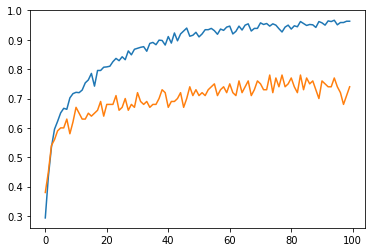

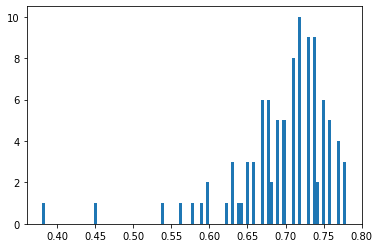

In [ ]:
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.show()

plt.hist(history.history['val_acc'], bins=100)
plt.show()

In [ ]:

songname = f'./genres/rock/rock.00000.au'

y, sr = librosa.load(songname, mono=True, duration=30)

out = get_features2(y, sr)

In [ ]:
out = np.array(out).reshape(1,37)

In [ ]:
out.shape

(1, 37)

In [ ]:
out = scaler.transform(out)

In [ ]:
print(out)

[[-0.02690168 -0.28780161 -0.27660395 -0.21895271 -0.32147562  0.2781953
   0.31028482 -0.65605257  0.26401823 -0.87942113  0.71996303 -1.03300635
   0.47878823 -0.78838959  0.62573777 -0.71319511  0.60099535 -1.09968739
   0.08155267 -0.4773205   0.18880677 -0.87535319  0.40799876 -0.01668224
  -0.11444064 -0.07569812  1.12639628  0.89248677  0.40919863  0.74039905
  -0.40429019 -0.66451179 -0.58669354  0.08835712  0.88386322 -0.76529203
  -0.85039474]]


In [ ]:
y = model.predict(out)

In [ ]:
print(y)
print(np.argmax(y))
print(genres.index("rock"))

[[1.1352468e-04 8.6303635e-06 1.4460984e-03 5.9904036e-04 1.0117482e-03
  2.9896492e-07 2.1483754e-03 1.5787937e-06 4.7789316e-04 9.9419290e-01]]
9
9


Сеть переобучается. Оптимизация была сделанна грубо, но некоторые рекомендации применимы. В частности дроп аут, функции активации и размер бача.